In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input, Conv2DTranspose, BatchNormalization, Reshape, Conv2D, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
def load_data():
    (x_train,y_train),(x_test,y_test) = mnist.load_data()
    x_train = (x_train.astype('float') - 127.5)/127.5
    x_train = x_train.reshape(60000,28,28,1)
    return (x_train,y_train,x_test,y_test)

In [5]:
(X_train,y_train,x_test,y_test) = load_data()
print(X_train.shape)

(60000, 28, 28, 1)


In [6]:
def adam_optimizer():
    return Adam(lr=0.0002,beta_1=0.5)

In [7]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    model.compile(loss='binary_crossentropy',optimizer= adam_optimizer())

    return model

In [8]:
g = make_generator_model()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)        

In [9]:
noise= np.random.normal(0,1,[100,100])

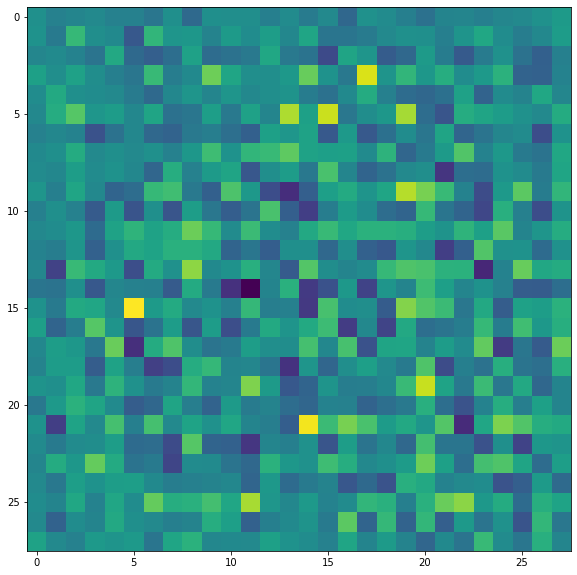

In [10]:
gi = g.predict(noise)
gi = gi.reshape(100,28,28)
plt.figure(figsize=(10,10))
plt.imshow(gi[99,:,:])

In [11]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    

    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

    return model

In [12]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [13]:
noise= np.random.normal(0,1,[100,100])
gi = g.predict(noise)
gi = tf.convert_to_tensor(gi)

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise)

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Tensor("sequential_4/dense_4/BiasAdd:0", shape=(1, 1), dtype=float32)


In [16]:
gi.shape

TensorShape([100, 28, 28, 1])

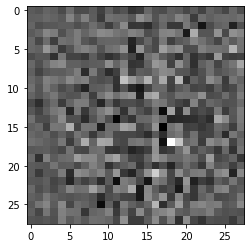

In [17]:
plt.imshow(gi[0, :, :,0], cmap='gray')

In [18]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('dcgan_generated_image %d.png' %epoch)

In [19]:
def create_gan(discriminator,generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input,outputs=gan_output)
    gan.compile(loss='binary_crossentropy',optimizer='adam')
    return gan

In [20]:
g = make_generator_model()
d = make_discriminator_model()
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28, 1)         2330944   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [21]:
d.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)             

C:\Users\irfan\Anaconda3\envs\ml\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [22]:
g.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_7 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 128)        

In [23]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] //batch_size
    
    # Creating GAN
    generator= make_generator_model()
    discriminator= make_discriminator_model()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for batch_idx in tqdm(range(batch_count)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            batch_start = batch_idx * batch_size
            image_batch =X_train[batch_start : (batch_start+batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 1


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.47it/s]

Epoch 2


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.54it/s]

Epoch 3


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.55it/s]

Epoch 4


  0%|▏                                                                                 | 1/468 [00:00<01:10,  6.64it/s]

Epoch 5


  0%|▏                                                                                 | 1/468 [00:00<01:10,  6.60it/s]

Epoch 6


  0%|▏                                                                                 | 1/468 [00:00<01:10,  6.64it/s]

Epoch 7


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.53it/s]

Epoch 8


  0%|▏                                                                                 | 1/468 [00:00<01:14,  6.25it/s]

Epoch 9


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.43it/s]

Epoch 10


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.55it/s]

Epoch 11


  0%|▏                                                                                 | 1/468 [00:00<01:15,  6.21it/s]

Epoch 12


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.57it/s]

Epoch 13


  0%|▏                                                                                 | 1/468 [00:00<01:13,  6.39it/s]

Epoch 14


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.55it/s]

Epoch 15


  0%|▏                                                                                 | 1/468 [00:00<01:10,  6.60it/s]

Epoch 16


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.43it/s]

Epoch 17


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.48it/s]

Epoch 18


  0%|▎                                                                                 | 2/468 [00:00<00:25, 18.56it/s]

Epoch 19


  0%|▎                                                                                 | 2/468 [00:00<00:24, 18.92it/s]

Epoch 20


  0%|▎                                                                                 | 2/468 [00:00<00:26, 17.43it/s]

Epoch 21


  0%|▎                                                                                 | 2/468 [00:00<00:23, 19.87it/s]

Epoch 22


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 23


  0%|▎                                                                                 | 2/468 [00:00<00:23, 19.47it/s]

Epoch 24


  0%|▎                                                                                 | 2/468 [00:00<00:24, 19.28it/s]

Epoch 25


  0%|▎                                                                                 | 2/468 [00:00<00:24, 19.23it/s]

Epoch 26


  0%|▎                                                                                 | 2/468 [00:00<00:23, 19.47it/s]

Epoch 27


  0%|▎                                                                                 | 2/468 [00:00<00:26, 17.28it/s]

Epoch 28


  0%|▎                                                                                 | 2/468 [00:00<00:24, 18.76it/s]

Epoch 29


  0%|▎                                                                                 | 2/468 [00:00<00:26, 17.29it/s]

Epoch 30


  0%|▎                                                                                 | 2/468 [00:00<00:25, 18.39it/s]

Epoch 31


  0%|▎                                                                                 | 2/468 [00:00<00:24, 18.94it/s]

Epoch 32


  0%|▎                                                                                 | 2/468 [00:00<00:24, 19.12it/s]

Epoch 33


  0%|▎                                                                                 | 2/468 [00:00<00:24, 19.33it/s]

Epoch 34


  0%|▎                                                                                 | 2/468 [00:00<00:25, 18.62it/s]

Epoch 35


  0%|▎                                                                                 | 2/468 [00:00<00:25, 18.23it/s]

Epoch 36


  0%|▎                                                                                 | 2/468 [00:00<00:27, 16.99it/s]

Epoch 37


  0%|▏                                                                                 | 1/468 [00:00<01:15,  6.17it/s]

Epoch 38


  0%|▏                                                                                 | 1/468 [00:00<01:11,  6.51it/s]

Epoch 39


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.47it/s]

Epoch 40


  0%|▏                                                                                 | 1/468 [00:00<01:13,  6.39it/s]

Epoch 41


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.47it/s]

Epoch 42


  0%|▏                                                                                 | 1/468 [00:00<01:25,  5.48it/s]

Epoch 43


  0%|▏                                                                                 | 1/468 [00:00<01:12,  6.42it/s]

Epoch 44


 54%|███████████████████████████████████████████▌                                    | 255/468 [00:39<00:32,  6.60it/s]

KeyboardInterrupt: 

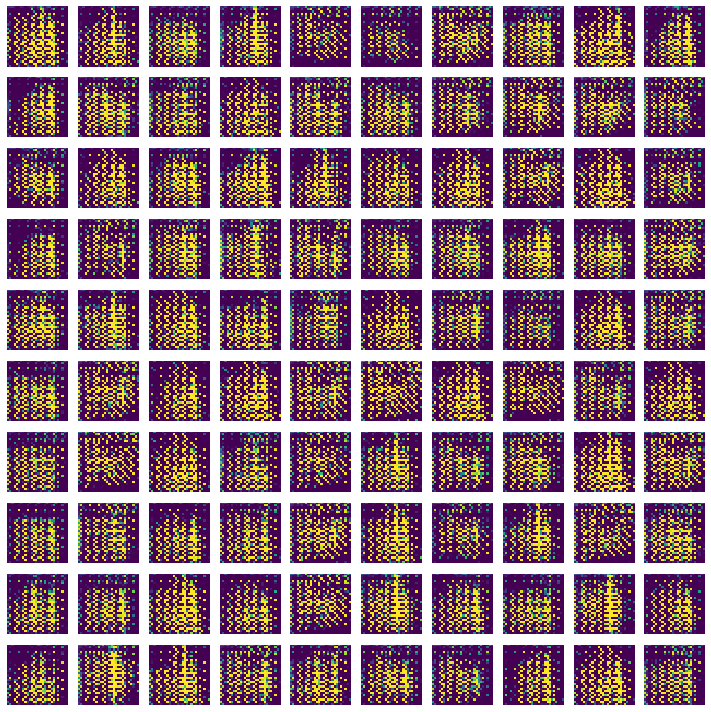

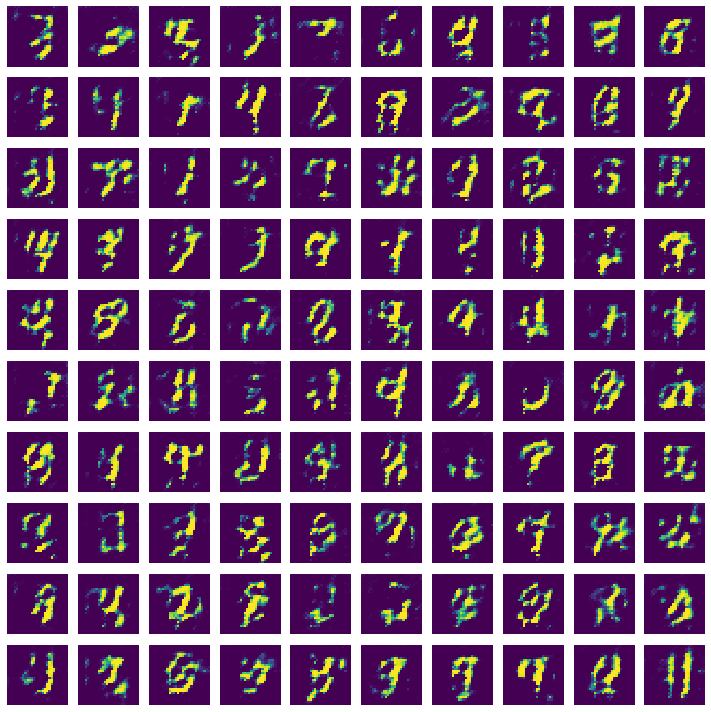

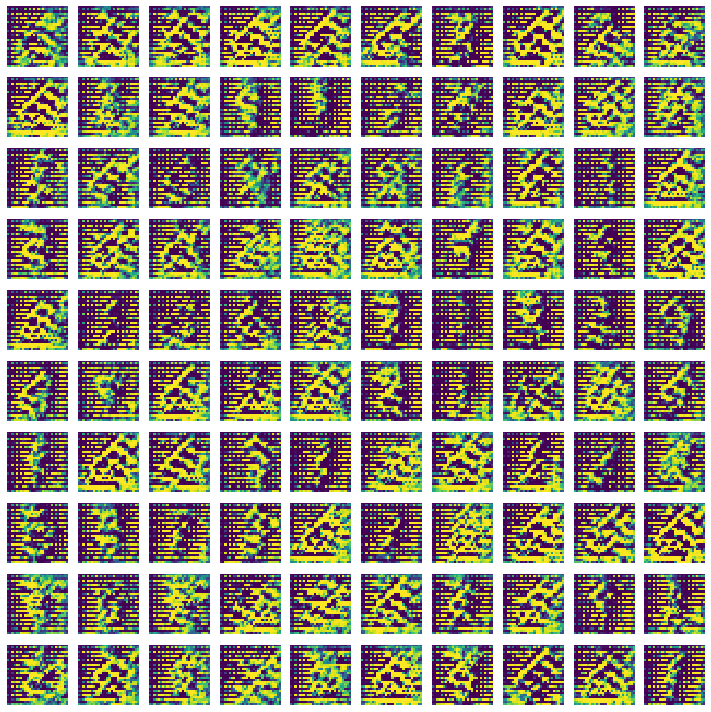

In [24]:
training(80,128)